# Options IV Calculation Test

This notebook tests the options data fetching and implied volatility (IV) calculation pipeline.


In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
from adapters.options_adapter import OptionsAdapter
from adapters.rates_adapter import RatesAdapter
from adapters.ticker_adapter import TickerAdapter
from models.options_data import OptionsRequest, OptionType
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from engines.IV_smile import IVEngine


In [256]:
from update_rates import updateRates
updateRates()

FRED_API_KEY present: yes
Starting updateRates...
Starting rate updates...
No new discount factor data available from 2025-12-20
No new SOFR data available from 2025-12-23
Rate updates completed.
updateRates completed.
Last discount_factors date: 2025-12-19
SOFR update was included.


## Setup

Initialize the adapter and create the options request.


In [257]:
adapter = OptionsAdapter()


today = date.today()
expiry_start = today + relativedelta(weeks=5)
expiry_end = today + relativedelta(weeks=56)

req = OptionsRequest(
    ticker="AAPL",
    optionType=OptionType.CALL,
    expiryStart=expiry_start,
    expiryEnd=expiry_end,
    moneynessMin=0.8,
    moneynessMax=1.2,
)


## Fetch Options Data


In [258]:
print(f"Requesting options for {req.ticker} until {expiry_end}...")
df = adapter.fetch_option_chain(req)
print(f"Fetched {len(df)} contracts.")


Requesting options for AAPL until 2027-01-19...
Fetched 232 contracts.


## Display Options Data


In [259]:
df[["optionType", "strike", "timeToExpiry", "midPrice", "expiry"]]

,optionType,strike,timeToExpiry,midPrice,expiry
0,call,220.0,0.104198,52.420,2026-01-30
1,call,225.0,0.104198,48.595,2026-01-30
2,call,230.0,0.104198,43.745,2026-01-30
3,call,235.0,0.104198,38.150,2026-01-30
4,call,240.0,0.104198,33.540,2026-01-30
...,...,...,...,...,...
227,call,290.0,1.063102,24.915,2027-01-15
228,call,300.0,1.063102,20.660,2027-01-15
229,call,310.0,1.063102,17.210,2027-01-15
230,call,320.0,1.063102,14.155,2027-01-15


## Calculate Implied Volatility


In [260]:
from engines.zero_rates import ZeroRatesEngine

df["rate"] = ZeroRatesEngine.interpolate_zero_rate(df, tte_col="timeToExpiry")

base_info = TickerAdapter.fetchBasic(req.ticker)
div = base_info.dividendYield
spot = base_info.spot
#
#print(f"Spot price: ${spot:.2f}")
#print(f"Risk-free rate: {rate:.4f}")
#print(f"Dividend yield: {div:.4f}%")
#print("\nCalculating IVs...")
#
surface_data = IVEngine.generateIVSmile(df, div/100, spot, OptionType.CALL) #type: ignore
surface_data.dropna(inplace=True)




In [261]:
print("\nIV Calculation Results:")
surface_data[["expiry", "iv"]]



IV Calculation Results:


,expiry,iv
1,2026-01-30,0.383282
2,2026-01-30,0.360492
3,2026-01-30,0.256425
4,2026-01-30,0.267902
5,2026-01-30,0.227362
...,...,...
227,2027-01-15,0.256665
228,2027-01-15,0.251050
229,2027-01-15,0.248447
230,2027-01-15,0.245377


In [262]:
import numpy as np
surface_data["F"] = spot * np.exp((surface_data["rate"] - div/100) * surface_data["T"])
surface_data["k"] = np.log(surface_data["K"] / surface_data["F"])
surface_data["w"] = surface_data["iv"] ** 2 * surface_data["T"]
surface_data[["K", "w", "k", "expiry" ,"F"]]
#print(f"Spot: {spot}")

,K,w,k,expiry,F
1,225.0,0.015307,-0.193391,2026-01-30,273.005445
2,230.0,0.013541,-0.171412,2026-01-30,273.005445
3,235.0,0.006851,-0.149906,2026-01-30,273.005445
4,240.0,0.007478,-0.128853,2026-01-30,273.005445
5,245.0,0.005386,-0.108234,2026-01-30,273.005445
...,...,...,...,...,...
227,290.0,0.070034,0.030916,2027-01-15,281.171612
228,300.0,0.067003,0.064817,2027-01-15,281.171612
229,310.0,0.065621,0.097607,2027-01-15,281.171612
230,320.0,0.064009,0.129356,2027-01-15,281.171612


In [263]:
thetas = surface_data.loc[surface_data["k"].abs().groupby(surface_data["T"]).idxmin()][["T", "k", "w"]].reset_index(drop=True)
thetas

,T,k,w
0,0.104198,0.007279,0.005318
1,0.161732,0.005454,0.008216
2,0.238330,0.003023,0.011740
3,0.315043,0.000602,0.017006
4,0.391755,-0.001816,0.024070
5,0.484906,-0.004752,0.029398
6,0.564358,-0.007165,0.034966
7,0.660248,0.007968,0.042154
8,0.736960,0.005659,0.045925
9,0.986390,-0.001848,0.064620


In [264]:
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import PchipInterpolator

In [265]:
iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
theta_iso = iso.fit_transform(thetas["T"], thetas["w"])

theta_spline = PchipInterpolator(thetas["T"], theta_iso, extrapolate=True)
surface_data["theta"] = theta_spline(surface_data["T"])
surface_data[["expiry", "k", "w", "theta"]]

,expiry,k,w,theta
1,2026-01-30,-0.193391,0.015307,0.005318
2,2026-01-30,-0.171412,0.013541,0.005318
3,2026-01-30,-0.149906,0.006851,0.005318
4,2026-01-30,-0.128853,0.007478,0.005318
5,2026-01-30,-0.108234,0.005386,0.005318
...,...,...,...,...
227,2027-01-15,0.030916,0.070034,0.075852
228,2027-01-15,0.064817,0.067003,0.075852
229,2027-01-15,0.097607,0.065621,0.075852
230,2027-01-15,0.129356,0.064009,0.075852


In [266]:
#theta_low = surface_data[surface_data["k"] <0].groupby("T")[["expiry","k","w","K","F","iv"]].max()
#theta_high = surface_data[surface_data["k"] >0].groupby("T")[["expiry","k","w","K","F","iv"]].min()
#interpolated_values = theta_high["w"] - (theta_high["w"] - theta_low["w"]) * (theta_high["k"] / (theta_high["k"] - theta_low["k"]))
#print(theta_high.iloc[-1])
#print(theta_low.iloc[-5:])
#surface_data["theta"] = surface_data["T"].map(interpolated_values)
surface_data[["expiry", "k", "w", "theta"]]




,expiry,k,w,theta
1,2026-01-30,-0.193391,0.015307,0.005318
2,2026-01-30,-0.171412,0.013541,0.005318
3,2026-01-30,-0.149906,0.006851,0.005318
4,2026-01-30,-0.128853,0.007478,0.005318
5,2026-01-30,-0.108234,0.005386,0.005318
...,...,...,...,...
227,2027-01-15,0.030916,0.070034,0.075852
228,2027-01-15,0.064817,0.067003,0.075852
229,2027-01-15,0.097607,0.065621,0.075852
230,2027-01-15,0.129356,0.064009,0.075852


In [267]:
vega = IVEngine._vega(surface_data["iv"], surface_data["K"], surface_data["T"], surface_data["rate"], div, surface_data["F"])
surface_data["vega"] = np.clip(vega, 1e-6, None)
print(f"Spot price: ${spot:.2f}")
surface_data[["expiry", "K", "k", "vega"]]

Spot price: $272.07


,expiry,K,k,vega
1,2026-01-30,225.0,-0.193391,13.845204
2,2026-01-30,230.0,-0.171412,15.979418
3,2026-01-30,235.0,-0.149906,12.324154
4,2026-01-30,240.0,-0.128853,18.054873
5,2026-01-30,245.0,-0.108234,20.002261
...,...,...,...,...
227,2027-01-15,290.0,0.030916,30.151866
228,2027-01-15,300.0,0.064817,23.629732
229,2027-01-15,310.0,0.097607,18.648637
230,2027-01-15,320.0,0.129356,14.326422


In [268]:
T_vals = surface_data["T"].values
T_unique = np.sort(surface_data["T"].unique())
T_to_index = {t: i for i, t in enumerate(T_unique)}
idx = np.array([T_to_index[t] for t in T_vals]) # index for each row to use on T_unique to find eta
x0 = np.r_[ -0.3, np.full(len(T_unique), 0.5) ]    # rho, eta_i-1



In [269]:
def ssvi_w(k, theta, phi, rho):
    w_ssvi = (
        1
        / 2
        * theta
        * (1 + rho * phi * k + np.sqrt((phi * k + rho) ** 2 + 1 - rho**2))
    )
    return w_ssvi


In [270]:
weights = surface_data.groupby("T")["vega"].transform(lambda x: x / x.sum()) * 100


In [271]:
def objective(x, theta, k, w_mkt, idx):
    rho_raw = x[0]
    rho = np.tanh(rho_raw) 
    eta = x[1:]
    phi = eta[idx] / np.sqrt(np.maximum(theta, 1e-12))
    w_model = ssvi_w(k, theta, phi, rho)
    error = (w_model - w_mkt)
    loss = np.dot(weights*error, error) 
    return loss 

In [272]:
#def butterfly_constraint(x):
#    eta, rho = x
#    return 2 - eta * (1 + abs(rho))

def make_constraints(n_expiries):
    cons = []
    for i in range(n_expiries):
        cons.append({
            "type": "ineq",
            "fun": lambda x, i=i: 2 - x[1+i] * (1 + abs(x[0]))
        })
    return cons


In [273]:
from scipy.optimize import minimize

bounds = [(-99.0, 99.0)] + [(1e-5, 2)] * len(T_unique)
w_mkt = surface_data["w"].values
k = surface_data["k"].values
theta = surface_data["theta"].values


res = minimize(
    objective,
    x0=x0,
    args=(theta, k, w_mkt, idx),
    method="SLSQP",
    bounds=bounds,
    constraints=make_constraints(len(T_unique))
)

#print(res.x)
print(f"Optimised Rho: {np.tanh(res.x[0]):.6f}")
print(f"Optimised Eta: {res.x[1:]}")

surface_data["w_ssvi"] = ssvi_w(k, theta, phi= res.x[1:][idx] / np.sqrt(np.maximum(theta, 1e-12)), rho=np.tanh(res.x[0])) #type: ignore


Optimised Rho: -0.411992
Optimised Eta: [0.68337759 0.88548865 0.81907057 0.89219067 0.69213749 0.77564856
 0.8001548  0.82897192 0.92612468 0.92200535 0.6257197 ]


In [274]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
total_residual = np.sum(surface_data["residuals"] ** 2)
print(f"SSVI Total Residual (MSE): {total_residual:.6f}")

vega_weighted_relative = relative * (vegas / np.sum(vegas))
print(f"Vega Weighted Mean Relative Error: {np.sum(vega_weighted_relative)*100:.4f}%")

SSVI Total Residual (MSE): 0.000770
Vega Weighted Mean Relative Error: 0.0691%


In [275]:
surface_data["iv_ssvi"] = np.sqrt(surface_data["w_ssvi"] / surface_data["T"])
surface_data["iv_error"] = (surface_data["iv_ssvi"] / surface_data["iv"] - 1)*100
vega_weighted_iv_error = surface_data["iv_error"].abs() * (surface_data["vega"] / np.sum(surface_data["vega"]))
print(f"Vega Weighted Mean IV Error: {np.sum(vega_weighted_iv_error):.4f}%")

Vega Weighted Mean IV Error: 1.9880%


In [276]:
rmse = np.sqrt(np.mean((surface_data["iv_ssvi"] - surface_data["iv"])**2))
print(f"IV RMSE: {rmse:.4f}")
avg_iv = np.mean(surface_data["iv"])
print(f"RMSE/Avg IV: {rmse/avg_iv*100:.4f}%")

IV RMSE: 0.0100
RMSE/Avg IV: 3.9649%


In [277]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
surface_data["relative_residuals"] = (surface_data["residuals"] / surface_data["w"])*100
surface_data[["expiry", "K", "iv", "w", "w_ssvi", "relative_residuals"]]

,expiry,K,iv,w,w_ssvi,relative_residuals
1,2026-01-30,225.0,0.383282,0.015307,0.011035,-27.909226
2,2026-01-30,230.0,0.360492,0.013541,0.010306,-23.887647
3,2026-01-30,235.0,0.256425,0.006851,0.009602,40.141816
4,2026-01-30,240.0,0.267902,0.007478,0.008922,19.306505
5,2026-01-30,245.0,0.227362,0.005386,0.008270,53.533943
...,...,...,...,...,...,...
227,2027-01-15,290.0,0.256665,0.070034,0.073736,5.286670
228,2027-01-15,300.0,0.251050,0.067003,0.071611,6.877524
229,2027-01-15,310.0,0.248447,0.065621,0.069763,6.313073
230,2027-01-15,320.0,0.245377,0.064009,0.068180,6.515987


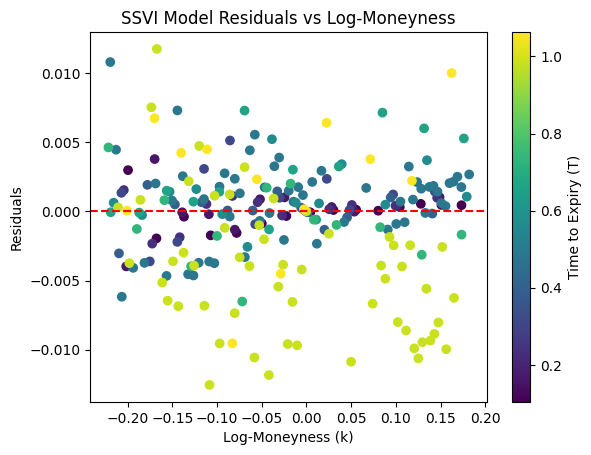

In [228]:
import matplotlib.pyplot as plt
plt.scatter(surface_data["k"], surface_data["residuals"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Residuals")
plt.title("SSVI Model Residuals vs Log-Moneyness")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [220]:
surface_data[["expiry", "K", "iv", "iv_ssvi", "iv_error"]]

,expiry,K,iv,iv_ssvi,iv_error
0,2026-01-30,155.0,0.380502,0.416443,9.445717
1,2026-01-30,160.0,0.425672,0.403103,-5.301981
2,2026-01-30,165.0,0.395026,0.390352,-1.183309
3,2026-01-30,170.0,0.399662,0.378348,-5.332809
4,2026-01-30,175.0,0.387089,0.367297,-5.113207
...,...,...,...,...,...
224,2027-01-15,195.0,0.455708,0.455870,0.035452
225,2027-01-15,200.0,0.447735,0.454420,1.493147
226,2027-01-15,210.0,0.447893,0.451851,0.883552
227,2027-01-15,220.0,0.447364,0.449688,0.519297


C:\Users\gryph\AppData\Local\Temp\ipykernel_29312\4148399127.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


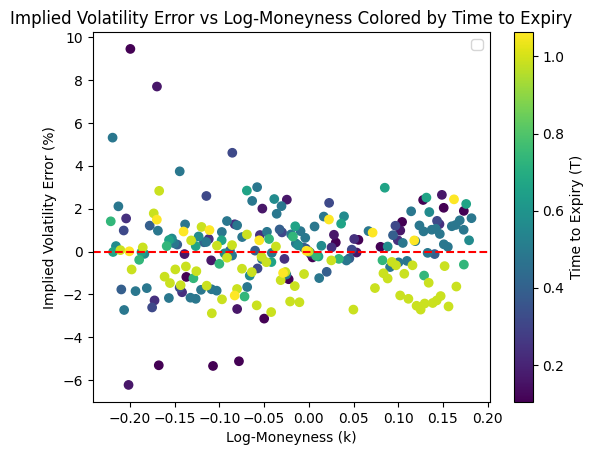

In [221]:
plt.scatter(surface_data["k"], surface_data["iv_error"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Implied Volatility Error (%)")
plt.title("Implied Volatility Error vs Log-Moneyness Colored by Time to Expiry")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

C:\Users\gryph\AppData\Local\Temp\ipykernel_29312\1990659495.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


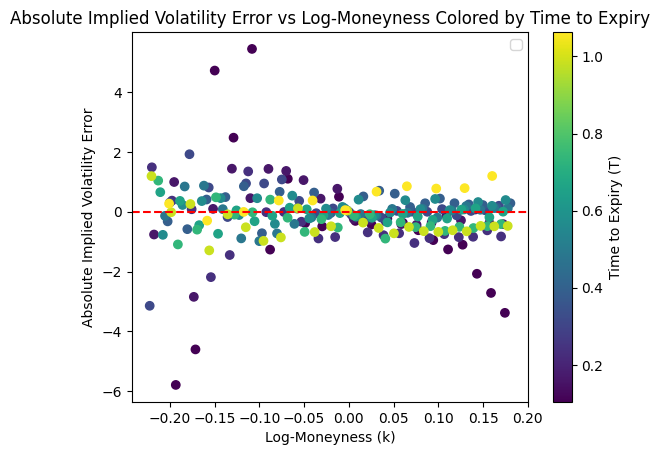

In [280]:
absolute_iv_error = (surface_data["iv_ssvi"] - surface_data["iv"])*100
plt.scatter(surface_data["k"], absolute_iv_error, c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Absolute Implied Volatility Error")
plt.title("Absolute Implied Volatility Error vs Log-Moneyness Colored by Time to Expiry")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()
